# VES Experiments for 1D Bayesian Optimization

In [1]:
from ves import *
import matplotlib.pyplot as plt
import numpy as np
import torch

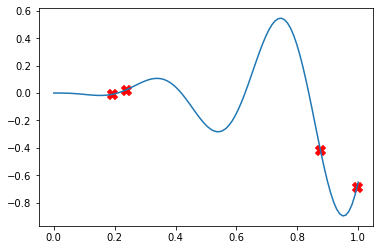

In [67]:
train_X = torch.load('1D_train_X.pt')
# train_X[0, 0] = 0.2
# train_X[1, 0] = 0.4
# train_X[2, 0] = 0.6
# train_X[3, 0] = 0.9 # Make sure the boundary is observed
def f(X, noise=0.0):
    return -np.sin(15*X)*X**2
train_Y = f(train_X, noise=0.0)
bounds = torch.Tensor([[torch.zeros(1), torch.ones(1)]])

# plot function f
tx = torch.linspace(0,1,100)
plt.plot(tx.squeeze().numpy(),f(tx).squeeze().numpy())
plt.scatter(train_X.numpy(),train_Y.numpy(),c='r',s=100,marker='X')
plt.show()

In [53]:
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.models.transforms.outcome import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.sampling.pathwise import draw_matheron_paths
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy
NUM_PATHS = 1024
outcome_transform = Standardize(m=1)
gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
_ = fit_gpytorch_mll(mll) # fit mll hyperpara
best_f = train_Y.max()
paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
ves_model = VariationalEntropySearch(gp, best_f=best_f, bounds=bounds, paths=paths)
ei_model = ExpectedImprovement(gp, best_f=best_f)
X = torch.linspace(0, 1, 201).unsqueeze(-1).to(torch.double)
mes_model = qMaxValueEntropy(gp, candidate_set=X)

In [54]:
def dt(d): return d.detach().numpy()
kvals, betavals, _, val = ves_model(X, return_ves=True)
ei = ei_model(X.unsqueeze(-1))
mes = mes_model(X.unsqueeze(-1))
val = dt(val.flatten())
val = (val - np.mean(val))/np.std(val)
ei = dt(ei.flatten())
ei = (ei - np.mean(ei))/np.std(ei)
mes = dt(mes.flatten())
mes = (mes - np.mean(mes))/np.std(mes)

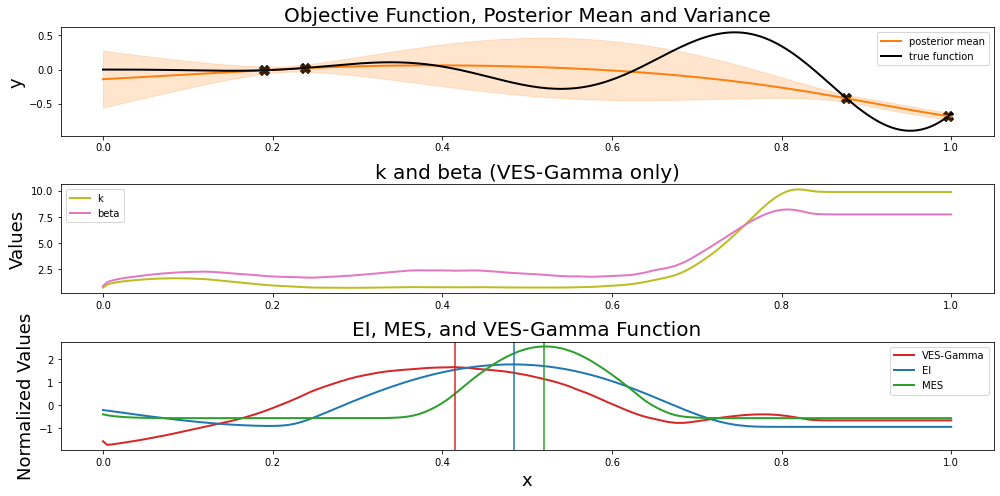

In [70]:
fig, axes = plt.subplots(3, 1, figsize=(14, 7))

posterior = gp.posterior(X)
m = dt(posterior.mean)
s = dt(posterior.variance.sqrt())
axes[0].plot(dt(X).flatten(), m.flatten(), linewidth=2, label='posterior mean', color='tab:orange')
if train_X is not None and f is not None:
    axes[0].plot(dt(X).flatten(), f(X).flatten(), linewidth=2, label='true function', color='black')
    axes[0].scatter(dt(train_X).flatten(), dt(train_Y).flatten(), marker='X', s=100, color='black')
else:
    axes[0].scatter(dt(gp.train_inputs[0]), dt(gp.train_targets))
axes[0].fill_between(dt(X).flatten(), (m - 2 * s).flatten(), (m + 2 * s).flatten(), alpha=0.2, color='tab:orange')
axes[0].legend()
axes[0].set_title('Objective Function, Posterior Mean and Variance', fontsize=20)
axes[0].set_ylabel('y', fontsize=18)

axes[1].plot(X.flatten(), dt(kvals.flatten()), linewidth=2, label=f'k', color='tab:olive')
axes[1].plot(X.flatten(), dt(betavals.flatten()), linewidth=2, label=f'beta', color='tab:pink')
axes[1].set_title('k and beta (VES-Gamma only)', fontsize=20)
axes[1].set_ylabel('Values', fontsize=18)

axes[2].plot(X.flatten(), val, label=f'VES-Gamma', linewidth=2, color='tab:red')
axes[2].plot(X.flatten(), ei, label=f'EI'.upper(), linewidth=2, color='tab:blue')
axes[2].plot(X.flatten(), mes, label=f'MES'.upper(), linewidth=2, color='tab:green')
axes[2].axvline(X.flatten()[val.argmax()], label=f'__nolabel__', color='tab:red')
axes[2].axvline(X.flatten()[ei.argmax()], label=f'__nolabel__', color='tab:blue')
axes[2].axvline(X.flatten()[mes.argmax()], label=f'__nolabel__', color='tab:green')
axes[2].set_title('EI, MES, and VES-Gamma Function', fontsize=20)
axes[2].set_xlabel('x', fontsize=18)
axes[2].set_ylabel(r'Normalized Values', fontsize=18)

plt.tight_layout()
axes[1].legend()
axes[2].legend()
# fig.savefig('ves_1d_small.pdf', dpi=300)

In [63]:
fig.savefig('ves_1d.png', dpi=300, bbox_inches='tight')

## Show EI/VES-Exp Equivalence

In [47]:
def normalize(x):
    x = x.detach().numpy().flatten()
    return (x - x.mean()) / x.std()

X = torch.linspace(0, 1, 201).unsqueeze(-1).to(torch.double)
max_Y = f(X).max().item()
posterior = gp.posterior(X)
mean = posterior.mean.detach().numpy().flatten()
std = posterior.variance.sqrt().detach().numpy().flatten()
# VES output
kvals, betavals, ei, val = ves_model(X, return_ves=True)
ei, val = normalize(ei), normalize(val)

# EI output
ei_model = ExpectedImprovement(gp, best_f=best_f)
ei_val = ei_model(X.unsqueeze(-1))
ei_val = normalize(ei_val)

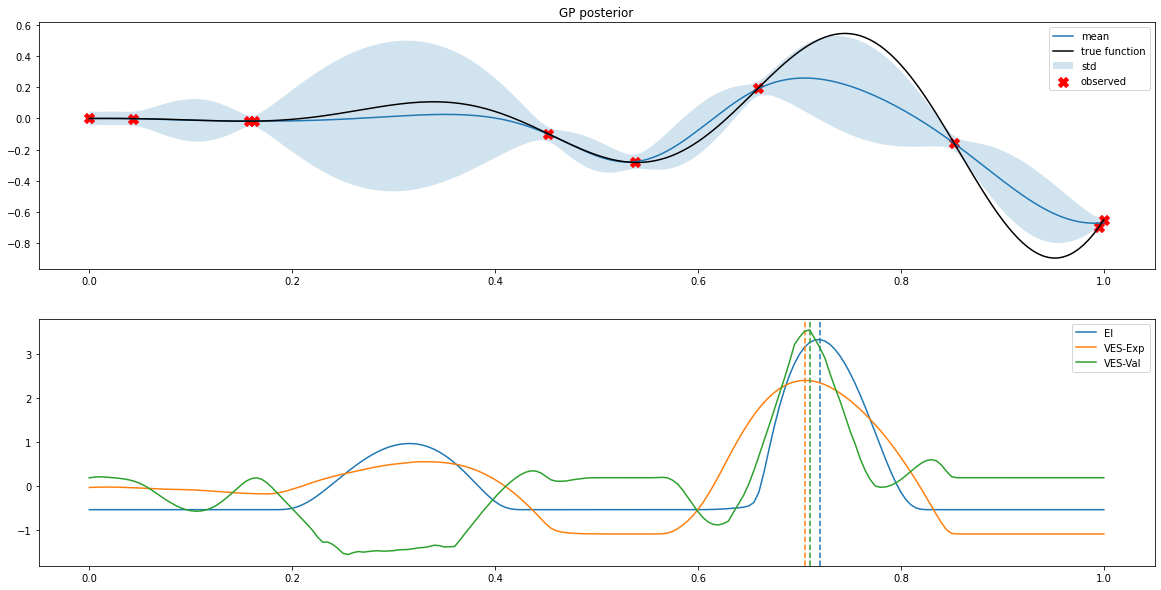

In [48]:
# plot
fig, axes = plt.subplots(2, 1, figsize=(20, 10))
axes[0].plot(X.squeeze().numpy(), mean, label='mean')
axes[0].fill_between(X.squeeze().numpy(), mean - 1.96*std, mean + 1.96*std, alpha=0.2, label='std')
axes[0].plot(X.squeeze().numpy(), f(X).squeeze().numpy(), label='true function', c='k')
axes[0].scatter(train_X.numpy(), train_Y.numpy(), c='r', s=100, marker='X', label='observed')
axes[0].legend()
axes[0].set_title('GP posterior')
axes[1].plot(X.squeeze().numpy(), ei_val, label='EI', c='tab:blue')
axes[1].axvline(X[np.argmax(ei_val)].squeeze().numpy(), c='tab:blue', linestyle='--')
axes[1].plot(X.squeeze().numpy(), ei, label='VES-Exp', c='tab:orange')
axes[1].axvline(X[np.argmax(ei)].squeeze().numpy(), c='tab:orange', linestyle='--')
axes[1].plot(X.squeeze().numpy(), val, label='VES-Val', c='tab:green')
axes[1].axvline(X[np.argmax(val)].squeeze().numpy(), c='tab:green', linestyle='--')
axes[1].legend()

## Start BO Iteratively

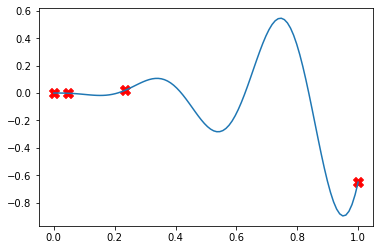

In [59]:
from tqdm import tqdm
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition.max_value_entropy_search import qMaxValueEntropy
from botorch.optim import optimize_acqf
# Iterative optimization
num_iter = 20
train_X_st = torch.rand(4, 1, dtype=torch.double)
train_X_st[0, 0] = 0.0
train_X_st[3, 0] = 1.0 # Make sure the boundary is observed
train_Y_st = f(train_X_st)
train_X, train_Y = train_X_st, train_Y_st

# plot function f
tx = torch.linspace(0,1,100)
plt.plot(tx.squeeze().numpy(),f(tx).squeeze().numpy())
plt.scatter(train_X.numpy(),train_Y.numpy(),c='r',s=100,marker='X')
plt.show()

In [61]:
vese, vesg, eia, mes = [], [], [], []
num_trials = 10

for _ in range(num_trials):
    # VES-Exp Iteration
    reg_ves_e = []
    train_X, train_Y = train_X_st, train_Y_st
    for t in tqdm(range(num_iter)):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ves_e.append(max_Y - best_f.item())
        paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
        model = VariationalEntropySearch(gp, best_f=best_f, bounds=bounds, paths=paths)
        X = torch.linspace(0, 1, 201).unsqueeze(-1).to(torch.double)
        with torch.no_grad():
            _, _, ei, val = model(X, return_ves=True)
        new_x = X[ei.argmax()]
        new_y = f(new_x)
        train_X = torch.cat([train_X, new_x.unsqueeze(-1)])
        train_Y = torch.cat([train_Y, new_y.unsqueeze(-1)])
    vese.append(reg_ves_e)

    # VES-Gamma Iteration
    train_X, train_Y = train_X_st, train_Y_st
    reg_ves_g = []
    for t in tqdm(range(num_iter)):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ves_g.append(max_Y - best_f.item())
        paths = draw_matheron_paths(gp, torch.Size([NUM_PATHS]))
        model = VariationalEntropySearch(gp, best_f=best_f, bounds=bounds, paths=paths)
        X = torch.linspace(0, 1, 201).unsqueeze(-1).to(torch.double)
        with torch.no_grad():
            _, _, ei, val = model(X, return_ves=True)
        new_x = X[val.argmax()]
        new_y = f(new_x)
        train_X = torch.cat([train_X, new_x.unsqueeze(-1)])
        train_Y = torch.cat([train_Y, new_y.unsqueeze(-1)])
    vesg.append(reg_ves_g)

    # EI Iteration
    train_X, train_Y = train_X_st, train_Y_st
    reg_ei = []
    for t in tqdm(range(num_iter)):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_ei.append(max_Y - best_f.item())
        EI = ExpectedImprovement(model=gp, best_f=best_f)
        new_x, _ = optimize_acqf(
            acq_function=EI,
            bounds=torch.tensor([[0.0] * 1, [1.0] * 1]),
            q=1,
            num_restarts=20,
            raw_samples=100,
            options={},
        )
        new_y = f(new_x)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
    eia.append(reg_ei)

    # MES Iteration
    train_X, train_Y = train_X_st, train_Y_st
    reg_mes = []
    candidate_set = torch.linspace(0, 1, 201).unsqueeze(-1).to(torch.double)
    for t in tqdm(range(num_iter)):
        outcome_transform = Standardize(m=1)
        gp = SingleTaskGP(train_X, train_Y, outcome_transform=outcome_transform) # gp model
        mll = ExactMarginalLogLikelihood(gp.likelihood, gp) # mll object
        _ = fit_gpytorch_mll(mll) # fit mll hyperpara
        best_f = train_Y.max()
        reg_mes.append(max_Y - best_f.item())
        qMES = qMaxValueEntropy(gp, candidate_set)
        new_x, _ = optimize_acqf(
            acq_function=qMES,
            bounds=torch.tensor([[0.0] * 1, [1.0] * 1]),
            q=1,
            num_restarts=10,
            raw_samples=512,
        )
        new_y = f(new_x)
        train_X = torch.cat([train_X, new_x])
        train_Y = torch.cat([train_Y, new_y])
    mes.append(reg_mes)

100%|██████████| 20/20 [00:05<00:00,  3.45it/s]


In [62]:
mes, eia, vese, vesg = np.asarray(mes), np.asarray(eia), np.asarray(vese), np.asarray(vesg)
mes_mean, ei_mean, vese_mean, vesg_mean = mes.mean(axis=0), eia.mean(axis=0), vese.mean(axis=0), vesg.mean(axis=0)
mes_std, ei_std, vese_std, vesg_std = mes.std(axis=0), eia.std(axis=0), vese.std(axis=0), vesg.std(axis=0)

(0.0, 5.0)

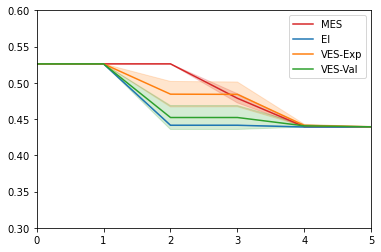

In [68]:
plt.plot(mes_mean, label='MES', c='tab:red')
plt.fill_between(np.arange(num_iter), mes_mean - 1.96*mes_std, mes_mean + 1.96*mes_std, alpha=0.2, color='tab:red')
plt.plot(ei_mean, label='EI', c='tab:blue')
plt.fill_between(np.arange(num_iter), ei_mean - 1.96*ei_std, ei_mean + 1.96*ei_std, alpha=0.2, color='tab:blue')
plt.plot(vese_mean, label='VES-Exp', c='tab:orange')
plt.fill_between(np.arange(num_iter), vese_mean - 1.96*vese_std, vese_mean + 1.96*vese_std, alpha=0.2, color='tab:orange')
plt.plot(vesg_mean, label='VES-Val', c='tab:green')
plt.fill_between(np.arange(num_iter), vesg_mean - 1.96*vesg_std, vesg_mean + 1.96*vesg_std, alpha=0.2, color='tab:green')
plt.legend()
plt.ylim(0.3, 0.6)
plt.xlim(0, 5)